## NERC in NLTK

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
# Getting the file STS.input.SMTeuroparl.txt from drive into a DataFrame
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
dt = pd.read_csv('/content/drive/MyDrive/data/ihlt/test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)
# Updating the DataFrame with a new column with STS.gs.SMTeuroparl.txt
dt['gs'] = pd.read_csv('/content/drive/MyDrive/data/ihlt/test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

Mounted at /content/drive


In [3]:
import re
# Getting a list of stop words
nltk.download('stopwords')
stopWordSet = set(nltk.corpus.stopwords.words('english'))

# Cleaning the words
def cleaner (sentenceList):
  
  # Transforming the tag of the words according to the tag_map
  sentenceList = [(pair[0], tagger(pair[1]), pair[2]) for pair in sentenceList]

  # Get the list into lowercase
  sentenceList = list(map(lambda word: (word[0].lower(), word[1], word[2]), sentenceList))

  # Filtering the ponctuation and stop words
  sentenceList = list(filter(lambda word : re.search('''[!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+''', word[0]) == None and word[0] not in stopWordSet, sentenceList))

  return sentenceList

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
nltk.download('omw-1.4')
nltk.download('wordnet')
wnl = nltk.stem.WordNetLemmatizer()

# Mapping the tags between Treebank and WordNet
tag_map = {
  'CC':"none", # coordin. conjunction (and, but, or)  
  'CD':"n", # cardinal number (one, two)             
  'DT':"none", # determiner (a, the)                    
  'EX':"r", # existential ‘there’ (there)           
  'FW':"none", # foreign word (mea culpa)             
  'IN':"r", # preposition/sub-conj (of, in, by)   
  'JJ':"a", # adjective (yellow)                  
  'JJR':"a", # adj., comparative (bigger)          
  'JJS':"a", # adj., superlative (wildest)           
  'LS':"none", # list item marker (1, 2, One)          
  'MD':"none", # modal (can, should)                    
  'NN':"n", # noun, sing. or mass (llama)          
  'NNS':"n", # noun, plural (llamas)                  
  'NNP':"n", # proper noun, sing. (IBM)              
  'NNPS':"n", # proper noun, plural (Carolinas)
  'PDT':"a", # predeterminer (all, both)            
  'POS':"none", # possessive ending (’s )               
  'PRP':"none", # personal pronoun (I, you, he)     
  'PRP$':"none", # possessive pronoun (your, one’s)    
  'RB':"r", # adverb (quickly, never)            
  'RBR':"r", # adverb, comparative (faster)        
  'RBS':"r", # adverb, superlative (fastest)     
  'RP':"a", # particle (up, off)
  'SYM':"none", # symbol (+,%, &)
  'TO':"none", # “to” (to)
  'UH':"none", # interjection (ah, oops)
  'VB':"v", # verb base form (eat)
  'VBD':"v", # verb past tense (ate)
  'VBG':"v", # verb gerund (eating)
  'VBN':"v", # verb past participle (eaten)
  'VBP':"v", # verb non-3sg pres (eat)
  'VBZ':"v", # verb 3sg pres (eats)
  'WDT':"none", # wh-determiner (which, that)
  'WP':"none", # wh-pronoun (what, who)
  'WP$':"none", # possessive (wh- whose)
  'WRB':"none", # wh-adverb (how, where)
}

# Transforming the tag of the words according to the tag_map
def tagger(tag):
  if tag in tag_map.keys():
    return tag_map[tag] 
  return "none"

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def NE_joiner (cleanedText):
  Text = []
  for pair in cleanedText:
    if pair[2] == 'O' or 'B-' in pair[2]: Text.append(pair[0])
    elif('I-' in pair[2]): Text[-1] = ' '.join((Text[-1], pair[0]))
  return Text

In [6]:
from nltk.metrics import jaccard_distance
import numpy as np
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Adding 3 empty columns to the DataFrame
# Just words
dt['jaccard_Word'] = ''
# words + PERSON, LOCATION, ORGZATION NEs classifcations merged
dt['jaccard_Word_NEs'] = ''

limit = len(dt[0][:])

for id in range(limit):

  # Tokenization and tagging
  tagsText1, tagsText2 = nltk.pos_tag(nltk.word_tokenize(dt.loc[id,0])), nltk.pos_tag(nltk.word_tokenize(dt.loc[id,1]))

  # Chunck
  chunckText1, chunckText2 = nltk.tree2conlltags(nltk.ne_chunk(tagsText1)), nltk.tree2conlltags(nltk.ne_chunk(tagsText2))

  # Cleaning 
  cleanedText1, cleanedText2 = cleaner(chunckText1), cleaner(chunckText2)

  # List of words
  Text1, Text2 = [pair[0] for pair in cleanedText1], [pair[0] for pair in cleanedText2]
  
  # List of words  + Merging correspondent NEs
  Text1_NEs, Text2_NEs = NE_joiner(cleanedText1), NE_joiner(cleanedText2)

  # Updating the DataFrame with the similarities according to the method jaccard
  dt.loc[id,'jaccard_Word'] = jaccard_distance(set(Text1), set(Text2))
  dt.loc[id,'jaccard_Word_NEs'] = jaccard_distance(set(Text1_NEs), set(Text2_NEs))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
display(dt)

,0,1,gs,jaccard_Word,jaccard_Word_NEs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.500,0.692308,0.692308
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.000,0.25,0.25
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.250,0.727273,0.727273
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.500,0.25,0.25
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.000,0.0,0.0
...,...,...,...,...,...
454,It is our job to continue to support Latvia wi...,It is of our duty of continue to support the c...,5.000,0.636364,0.636364
455,The vote will take place today at 5.30 p.m.,Vote will take place at 17 h 30.,4.750,0.571429,0.571429
456,Neither was there a qualified majority within ...,There was no qualified majority in this Parlia...,5.000,0.636364,0.636364
457,Let me remind you that our allies include ferv...,"I hold you recall that our allies, there are e...",4.000,0.8,0.8


In [8]:
from scipy.stats import pearsonr

# Get the correlation and the p-value between gs and jaccard
corr, p = pearsonr(dt['gs'], dt['jaccard_Word'])
print("Only Words -> Correlation coefficient:", corr)
print("Only Words -> p-value:", p)

corr, p = pearsonr(dt['gs'], dt['jaccard_Word_NEs'])
print("\nWords + NEs -> Correlation coefficient:", corr)
print("Words + NEs -> p-value:", p)

Only Words -> Correlation coefficient: -0.48094173868814033
Only Words -> p-value: 6.04463003283716e-28

Words + NEs -> Correlation coefficient: -0.460948400467054
Words + NEs -> p-value: 1.589479127847856e-25


# **Conclusion:**

This updated version of the code applies the Maximum entropy model from NLTK (PERSON, LOCATION, ORGANIZATION) trained with ACE corpus to obtain the Jaccard Similarity and the Pearson Correlation.

Firstly, it is chosen to represent the words in their basic form, in order to comprehend in isolation the effect of considering NEs.

In this analysis 2 approaches were considered:

*   **1 - Only Words:**

    Correlation coefficient: -0.481

    p-value: 6.044e-28

*   **2 - Words considering the PERSON, LOCATION, ORGANIZATION NEs classifications:**

    Correlation coefficient: -0.461

    p-value: 1.589e-25


In both methods, it is visible a negative non-linear correlation between the gold standard and Jaccard methods and, even though the p-value is diminished, meaning that the null hypothesis is false and there is a correlation between the variables, the amount of data is insufficient to make such a conclusion.

Furthermore, by comparing both correlations it is understandable that, for this data set, if only words are considered the correlation between the Jaccard similarity and the Pearson correlation is higher.

Particularly, it is not registered a single improvement in the similarity between the phrases when the NEs are considered. This is due to the fact that, by considering an NE and merging subsequent words with the same label associated, the number of instances to compare is reduced.
For example, in the following texts, the Jaccard similarity perceives that 2 strings are the same (2/3):

Text1 = ['The', 'european', 'union']
Text2 = ['A', 'european', 'union']

However, when considering NEs, the texts would be:

Text1 = ['The', 'european union']
Text2 = ['A', 'european union']

In which, for the same phrases, only one string is actually similar (1/2). Consequentially, the overall similarity decreases.

Additionally, the previous analysis is not enough to point out that this approach is not beneficial in a text comparison. Firstly, as 95.4% of the words do not belong to the first 3 categories referred, in almost all the cases the words are assigned with 'O'.
Then, the dataset is not big enough or with a considerable amount of variety in the examples.
Additionally, the method is sensitive to the order of the words and lower/upper case configurations that can be prejudicial occasionally.
Finally, when 2 phrases should hold very high similarity, using NEs might result in a decrement in the similarity and the correlation, since fewer instances with a unitary Jaccard classification are being considered. Nonetheless, when 2 phrases should have extremely low similarity, decreasing the instances by considering NEs might lead to better correlation results.

To conclude, using NEs might be helpful depending on the number of classifications provided and the dataset considered. Furthermore, it is necessary to denote that the correlation obtained is not sufficiently satisfying.

# NLTK RegexpParser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.8 MB/s 
(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  (PP at/IN (NP the/DT cat/NN))
  (PP in/IN (NP New/NNP York/NNP)))


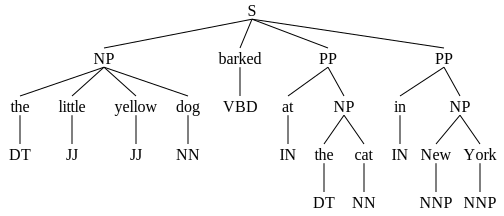

In [9]:
!pip install svgling
import svgling
# Sentence considered
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"),\
            ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN"), \
            ("in", "IN"), ("New", "NNP"), ("York", "NNP")]

# Grammar definition
grammar = """NP: {<NNP>*|<DT>?<JJ>*<NN>}
             PP: {<IN><NP>}"""

# Parser
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)

# Output
print(result)

# Output tree
svgling.draw_tree(result)